In [1]:
# imports 
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd 

/Users/noelkamm/eeg_llm/eeg_tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define global variables 
NUM_OBSV = 10000                     # number of generated observations  
SEQ_LEN = 100                       # length of the sequence 
NOISE = 0.5                           # level of noise 
MEAN1 = 1                           # mean of the first pulse 
STD1 = 0.3                          # standard deviation of the first pulse 
MEAN2 = 2                           # mean of the second pulse 
STD2 = 0.3                          # standard deviation of the second pulse 
TEST_SIZE = 0.2                     # size of the test set 
BATCH_SIZE = 16                     # batch size 
RANDOM_STATE = 42                   # random initialization for reproducability 
PRED_LENGTH = 50                    # length of the prediction 
CONTEXT_LENGTH = 49                 # length of the context window 
NUM_TIME_FEAT = 1                   # number of time features 
ENC_LAYERS = 2                      # number of encoding layers 
DEC_LAYERS = 2                      # number of decoding layers 
INPUT_FEAT = 2                      # number of input features 
LAG_SEQ = [1]                       # lag sequence 
D_MODEL = 64                        # dimension of the model 
N_HEADS = 8                         # number of attention heads
DISTR = 'normal'                    # output distribution  
NUM_SAMPLES = 1                    # number of parallel generated samples 
NUM_EPOCHS = 20                     # number of epochs 
LEARNING_RATE = 1e-3                # learning rate 

In [3]:
# data generation
def gaussian(t, mean, std):
    """
    Computes the Gaussian (normal distribution) value for each point in time.
    """
    
    return 1/np.sqrt(2*np.pi*std**2)*np.exp(-(t-mean)**2/(2*std**2))


def generate_pulse_data(num_samples=NUM_OBSV, seq_len=SEQ_LEN, noise=NOISE, mean1=MEAN1, std1=STD1, mean2=MEAN2, std2=STD2, seed=42):
    """
    Generates synthetic pulse data with time-shifted Gaussian pulses and random noise.
    """
    np.random.seed(seed)
    data = []

    for _ in range(num_samples):
        phase_shift = np.random.randn(1)
        t = np.linspace(0, 5, seq_len) + phase_shift

        pulse1 = gaussian(t, mean1, std1) + noise * np.random.randn(seq_len)
        pulse2 = gaussian(t, mean2, std2) + noise * np.random.randn(seq_len)

        sample = np.stack([pulse1, pulse2], axis=1)
        data.append(sample)
    data = np.array(data)
    return data

def split_data(data, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """
    Splits the input data into training and testing set.
    """

    X_train, y = train_test_split(data, test_size=test_size, random_state=random_state)
    return X_train, y

def create_data_loaders(X_train, X_test, batch_size=BATCH_SIZE, shuffle=True):
    """
    Converts training and testing data into PyTorch DataLoader objects.
    """
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

def split_past_future(batch, num_future_points=PRED_LENGTH):
    """
    Splits a batch of time series data into past and future segments.
    """

    past_values = batch[:, :-num_future_points, :]
    future_values = batch[:, -num_future_points:, :]
    return past_values, future_values

In [4]:
# model initialization and training
def create_model_config(prediction_length=PRED_LENGTH, context_length=CONTEXT_LENGTH, num_time_features=NUM_TIME_FEAT, 
                        encoder_layers=ENC_LAYERS, decoder_layers=DEC_LAYERS, d_model=D_MODEL, n_heads=N_HEADS, 
                        input_size=INPUT_FEAT, lags_sequence=LAG_SEQ, num_parallel_samples=NUM_SAMPLES, distribution_output=DISTR):
    """
    Creates a configuration for a Time Series Transformer model.
    """
    config = TimeSeriesTransformerConfig(
        prediction_length=prediction_length,
        context_length=context_length,
        num_time_features=num_time_features,
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model,
        n_heads=n_heads,
        input_size=input_size,
        lags_sequence=lags_sequence,
        num_parallel_samples=num_parallel_samples,
        distribution_output=distribution_output,
    )
    return config

def train_model(model, train_loader, num_future_points=PRED_LENGTH, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE):
    """
    Trains Times Series Transformer model on provided training data for signal forecasting.
    """
    optim = Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0.0  

        for batch in train_loader:
            past_values, future_values = split_past_future(batch[0], num_future_points=num_future_points)

            batch = {
                "past_values": past_values,  
                "future_values": future_values, 
                "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  
                "past_observed_mask": torch.ones_like(past_values),  
                "future_observed_mask": torch.ones_like(future_values),  
                "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  
                "return_dict": True
            }

            outputs = model(
                past_values=batch["past_values"],
                past_time_features=batch["past_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                future_observed_mask=batch["future_observed_mask"],
                future_values=batch["future_values"],
                future_time_features=batch["future_time_features"],
                return_dict=batch["return_dict"]
            )

            loss = outputs.loss
            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item()  

        epoch_loss = total_loss / len(train_loader)  
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [5]:
def generate_predictions(model, test_loader, prediction_length=PRED_LENGTH):
    """
    Predicts distributional parameters for future time points of test set using
    trained Time Series Transformer model.
    """
    # Store temporary buffers per parameter
    params_lst = []

    model.eval()

    for batch in test_loader:
        past_values, future_values = split_past_future(
            batch[0], num_future_points=prediction_length
        )

        batch_dict = {
            "past_values": past_values,  
            "future_values": future_values,  
            "past_time_features": torch.arange(past_values.size(1))
                                     .unsqueeze(0).unsqueeze(2).float()
                                     .repeat(past_values.size(0), 1, 1),
            "past_observed_mask": torch.ones_like(past_values),
            "future_observed_mask": torch.ones_like(future_values),
            "future_time_features": torch.arange(
                                        past_values.size(1),
                                        past_values.size(1) + prediction_length
                                    ).unsqueeze(0).unsqueeze(2).float()
                                     .repeat(future_values.size(0), 1, 1),
            "return_dict": True,
        }

        with torch.no_grad():
            outputs = model(
                past_values=batch_dict["past_values"],
                past_time_features=batch_dict["past_time_features"],
                past_observed_mask=batch_dict["past_observed_mask"],
                future_observed_mask=batch_dict["future_observed_mask"],
                future_values=batch_dict["future_values"],
                future_time_features=batch_dict["future_time_features"],
                return_dict=batch_dict["return_dict"],
            )

        
        
        scale = outputs.scale
        loc = outputs.loc
        params = (scale * outputs.params[0] + loc, scale * outputs.params[1])

        if params[0].shape[0] == 16:
            params_lst.append(params)      

    return params_lst


In [6]:
def arrange_params(params_lst):
    """
    Processes test data and calculates mean and standard deviation of pulse1 and pulse2
    for each time point, averaged over batches.
    """
    # Number of time points from the first batch
    first_mean, first_std = params_lst[0]
    num_time_points = first_mean.shape[1]

    # Initialize list of dicts: one dict per time point
    timepoint_dicts = [
        {"mu_pulse1": 0.0, "sigma_pulse1": 0.0,
         "mu_pulse2": 0.0, "sigma_pulse2": 0.0}
        for _ in range(num_time_points)
    ]
    num_batches = len(params_lst)

    # Iterate through each batch to calculate the means and standard deviations
    for batch in params_lst:
        mean, std_dev = batch[0], batch[1]

        # Loop over time points as before
        for time_point in range(mean.shape[1]):
            mu_pulse1 = mean[:, time_point, 0].detach().cpu().numpy()
            sigma_pulse1 = std_dev[:, time_point, 0].detach().cpu().numpy()
            mu_pulse2 = mean[:, time_point, 1].detach().cpu().numpy()
            sigma_pulse2 = std_dev[:, time_point, 1].detach().cpu().numpy()

            # Accumulate averages over samples in the batch
            timepoint_dicts[time_point]["mu_pulse1"] += np.mean(mu_pulse1)
            timepoint_dicts[time_point]["sigma_pulse1"] += np.mean(sigma_pulse1)
            timepoint_dicts[time_point]["mu_pulse2"] += np.mean(mu_pulse2)
            timepoint_dicts[time_point]["sigma_pulse2"] += np.mean(sigma_pulse2)

    # Average the accumulated values over the number of batches
    for tp_dict in timepoint_dicts:
        tp_dict["mu_pulse1"] /= num_batches
        tp_dict["sigma_pulse1"] /= num_batches
        tp_dict["mu_pulse2"] /= num_batches
        tp_dict["sigma_pulse2"] /= num_batches

    # Return DataFrame with a single row (index 0) and columns = time points
    return pd.DataFrame([timepoint_dicts])


def get_pulse_mus(epoch_df):
    """
    Get mean and standard deviation of pulse1 and pulse2. 
    """
    # Since we only have one epoch, use the first (and only) row
    row = epoch_df.iloc[0, :]

    # Extract mean and sigma values for pulse1 and pulse2 across samples
    pulse1_mus = row.apply(lambda x: x["mu_pulse1"]).values
    pulse1_sigmas = row.apply(lambda x: x["sigma_pulse1"]).values
    pulse2_mus = row.apply(lambda x: x["mu_pulse2"]).values
    pulse2_sigmas = row.apply(lambda x: x["sigma_pulse2"]).values

    return pulse1_mus, pulse2_mus, pulse1_sigmas, pulse2_sigmas

In [7]:
# train model
data = generate_pulse_data()
data_avg = np.mean(data, axis=0)
X_train, y = split_data(data)
train_loader, test_loader = create_data_loaders(X_train, y)
config = create_model_config()
model = TimeSeriesTransformerForPrediction(config)
train_model(model, train_loader)

Epoch 1/20, Loss: 1.5960
Epoch 2/20, Loss: 1.5066
Epoch 3/20, Loss: 1.4913
Epoch 4/20, Loss: 1.4870
Epoch 5/20, Loss: 1.4829
Epoch 6/20, Loss: 1.4805
Epoch 7/20, Loss: 1.4776
Epoch 8/20, Loss: 1.4780
Epoch 9/20, Loss: 1.4780
Epoch 10/20, Loss: 1.4751
Epoch 11/20, Loss: 1.4729
Epoch 12/20, Loss: 1.4768
Epoch 13/20, Loss: 1.4734
Epoch 14/20, Loss: 1.4736
Epoch 15/20, Loss: 1.4761
Epoch 16/20, Loss: 1.4734
Epoch 17/20, Loss: 1.4725
Epoch 18/20, Loss: 1.4747
Epoch 19/20, Loss: 1.4713
Epoch 20/20, Loss: 1.4708


In [8]:
# save model 
model.save_pretrained("../models")

In [9]:
# get distributional parameters 
params = generate_predictions(model, test_loader)
params_df = arrange_params(params)
pulse1_mus, pulse2_mus, pulse1_sigmas, pulse2_sigmas = get_pulse_mus(params_df)

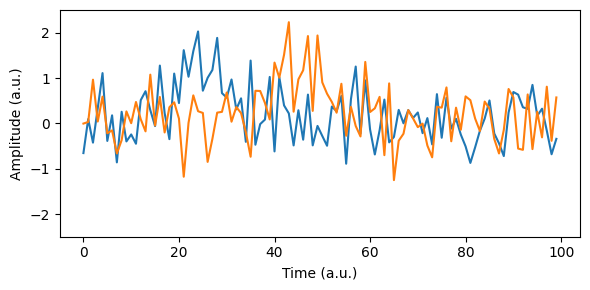

In [10]:
i = 42  
t = np.arange(data.shape[1]) 

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t, data[i, :, 0])
ax.plot(t, data[i, :, 1])

ax.set_ylim(-2.5, 2.5)

ax.set_xlabel("Time (a.u.)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.savefig(f"../figs/synthetic_trial_{i}.pdf", format="pdf", dpi=300)
plt.show()

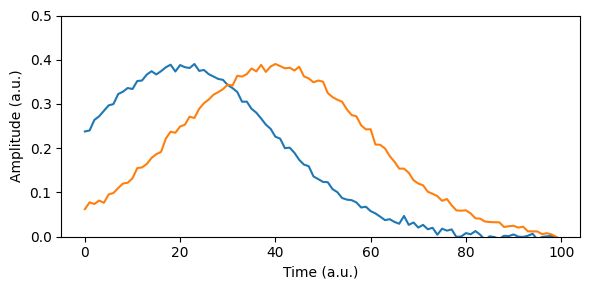

In [11]:
t = np.arange(data.shape[1]) 

fig, ax = plt.subplots(figsize=(6, 3))

plt.plot(t, data_avg[:, 0])
plt.plot(t, data_avg[:, 1])

ax.set_ylim(0, 0.5)

ax.set_xlabel("Time (a.u.)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.savefig(f"../figs/average_trials.pdf", format="pdf", dpi=300)
plt.show()

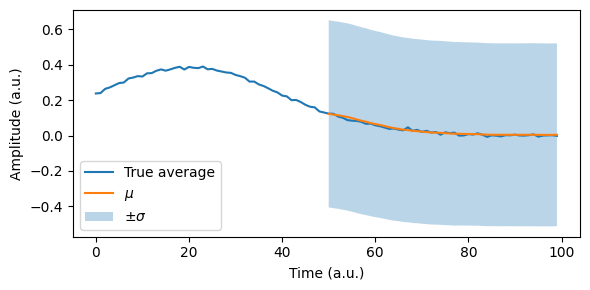

In [12]:

t_x = np.arange(100)                      
t_y = np.arange(50) + 50                  

# Figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t_x, data_avg[:, 0],  label='True average')

ax.plot(t_y, pulse1_mus, label=r'$\mu$')

# Blue filling: ±σ
ax.fill_between(
    t_y,
    pulse1_mus - pulse1_sigmas,
    pulse1_mus + pulse1_sigmas,
    alpha=0.3,
    label=r'$\pm \sigma$'
)

# Labels and legend
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend()

fig.tight_layout()

# Save as PDF
fig.savefig('../figs/prediction1.pdf')
plt.show()

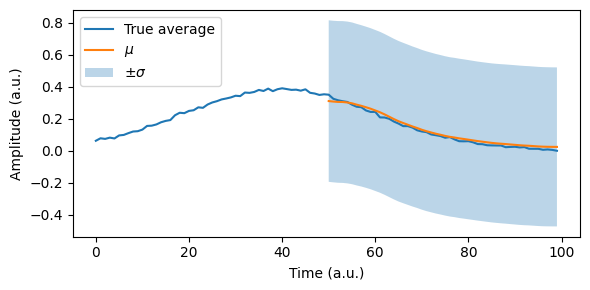

In [13]:

t_x = np.arange(100)                      
t_y = np.arange(50) + 50                  

# Figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t_x, data_avg[:, 1],  label='True average')

ax.plot(t_y, pulse2_mus, label=r'$\mu$')

# Blue filling: ±σ
ax.fill_between(
    t_y,
    pulse2_mus - pulse2_sigmas,
    pulse2_mus + pulse2_sigmas,
    alpha=0.3,
    label=r'$\pm \sigma$'
)

# Labels and legend
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend()

fig.tight_layout()

# Save as PDF
fig.savefig('../figs/prediction2.pdf')
plt.show()